# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

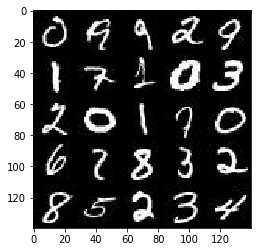

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

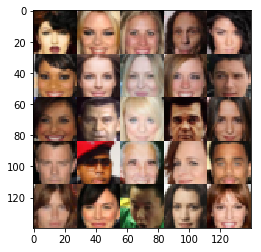

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl-tf1.3/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl-tf1.3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl-tf1.3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl-tf1.3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl-tf1.3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #for leaky ReLU (paper)
    alpha = 0.2
    
    with tf.variable_scope( 'discriminator', reuse=reuse ):
        #Input layer 28x28x(1|3)
        x1 = tf.layers.conv2d( images, 128, 5, strides=2, padding='same'
                             #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                              , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum( alpha*x1, x1 )
        #14x14x128      
        
        x2 = tf.layers.conv2d( x1, 256, 5, strides=2, padding='same'
                             #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                              , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization( x2, training=True )
        x2 = tf.maximum( alpha*x2, x2 )
        #7x7x256
        
        x3 = tf.layers.conv2d( x2, 512, 5, strides=2, padding='same'
                             #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                              , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization( x3, training=True )
        x3 = tf.maximum( alpha*x3, x3 )
        #4x4x514
        
        #Flatten vector
        flat = tf.reshape( x3, (-1, 4*4*512) )
        logits = tf.layers.dense( flat, 1 )
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    #kernel_initializer=tf.contrib.layers.xavier_initializer()
    
    #for leaky ReLU (paper)
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=reuse):
        #Fully connected
        x1 = tf.layers.dense(z, 7*7*512)
        
        '''
        x1 = tf.reshape( x1, (-1, 4, 4, 512) )
        x1 = tf.layers.batch_normalization( x1, training=is_train )
        x1 = tf.nn.relu(x1)
        #x1 = tf.maximum( alpha*x1, x1 )        
        #4x4x512
        
        x2 = tf.layers.conv2d_transpose( x1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization( x2, training=is_train )
        x2 = tf.nn.relu(x2)
        #x2 = tf.maximum( alpha*x2, x2 )
        #7x7x256
        '''
        
        #Reshape to 7x7x512
        x1 = tf.reshape( x1, (-1, 7, 7, 512) )
        x1 = tf.layers.batch_normalization( x1, training=is_train )
        #x1 = tf.nn.relu(x1)
        x1 = tf.maximum( alpha*x1, x1 )        
        #7x7x512
        
        x2 = tf.layers.conv2d_transpose( x1, 256, 5, strides=2, padding='same'
                                        #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                                        , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization( x2, training=is_train )
        #x2 = tf.nn.relu(x2)
        x2 = tf.maximum( alpha*x2, x2 )
        #14x14x256
        
        x3 = tf.layers.conv2d_transpose( x2, 128, 5, strides=2, padding='same'
                                        #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                                        , kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization( x3, training=is_train )
        #x3 = tf.nn.relu(x3)
        x3 = tf.maximum( alpha*x3, x3 )
        #28x28x128       

        logits = tf.layers.conv2d_transpose( x3, out_channel_dim, 5, strides=1, padding='same'
                                        #, kernel_initializer=tf.random_normal_initializer(stddev=0.01))
                                        , kernel_initializer=tf.contrib.layers.xavier_initializer())
        #28x28xout_channel_dim
        
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # For label smoothing
    smooth = 0.1
    
    g_model = generator( input_z, out_channel_dim )
    d_model_real, d_logits_real = discriminator( input_real )
    d_model_fake, d_logits_fake = discriminator( g_model, reuse=True )
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits( logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth) ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits( logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits( logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Weights and bias
    t_vars = tf.trainable_variables()
    d_vars = [ var for var in t_vars if var.name.startswith('discriminator') ]
    g_vars = [ var for var in t_vars if var.name.startswith('generator') ]
    
    # Optimization
    with tf.control_dependencies( tf.get_collection( tf.GraphKeys.UPDATE_OPS ) ):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_images = 25
    print_every = 40
    show_every = 400
       
    sample_z = tf.constant(np.random.uniform(-1, 1, size=(n_images,z_dim)), dtype=tf.float32)
    steps = 0
    
    n_examples, image_width, image_height, image_channels = data_shape
        
    input_real, input_z, learning_rate_input = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_input, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                # generator input z
                batch_z = np.random.uniform( -1, 1, size=(batch_size, z_dim))
                #batch_z2 = np.random.uniform( -1, 1, size=(batch_size, z_dim))
                
                # optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z:batch_z, learning_rate_input:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, input_real:batch_images, learning_rate_input:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, input_real:batch_images, learning_rate_input:learning_rate})
                
                if steps % print_every == 0:
                    #print losses
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step {}, Epoch {}/{}...".format(steps, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))  
                 
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, sample_z, image_channels, data_image_mode)      
        
        print("Final examples")
        show_generator_output(sess, n_images, sample_z, image_channels, data_image_mode)   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 20, Epoch 1/2... Discriminator Loss: 8.8833... Generator Loss: 0.0010
Step 40, Epoch 1/2... Discriminator Loss: 2.0418... Generator Loss: 0.5761
Step 60, Epoch 1/2... Discriminator Loss: 1.8738... Generator Loss: 0.6163
Step 80, Epoch 1/2... Discriminator Loss: 2.0149... Generator Loss: 0.3400
Step 100, Epoch 1/2... Discriminator Loss: 2.2226... Generator Loss: 0.2172
Step 120, Epoch 1/2... Discriminator Loss: 1.7924... Generator Loss: 0.5412
Step 140, Epoch 1/2... Discriminator Loss: 1.6974... Generator Loss: 0.3958
Step 160, Epoch 1/2... Discriminator Loss: 1.7538... Generator Loss: 0.3653
Step 180, Epoch 1/2... Discriminator Loss: 1.7997... Generator Loss: 0.3534
Step 200, Epoch 1/2... Discriminator Loss: 1.6290... Generator Loss: 1.1421


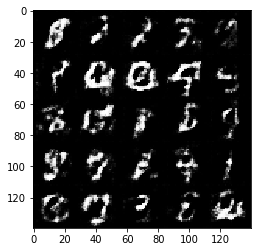

Step 220, Epoch 1/2... Discriminator Loss: 1.6050... Generator Loss: 0.4149
Step 240, Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.7688
Step 260, Epoch 1/2... Discriminator Loss: 1.7008... Generator Loss: 0.8934
Step 280, Epoch 1/2... Discriminator Loss: 1.7157... Generator Loss: 0.6347
Step 300, Epoch 1/2... Discriminator Loss: 1.8027... Generator Loss: 0.3374
Step 320, Epoch 1/2... Discriminator Loss: 1.7046... Generator Loss: 1.3791
Step 340, Epoch 1/2... Discriminator Loss: 1.5797... Generator Loss: 0.7405
Step 360, Epoch 1/2... Discriminator Loss: 1.5580... Generator Loss: 0.4811
Step 380, Epoch 1/2... Discriminator Loss: 1.7488... Generator Loss: 0.3577
Step 400, Epoch 1/2... Discriminator Loss: 1.6199... Generator Loss: 0.4510


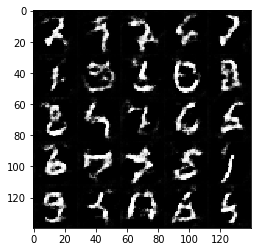

Step 420, Epoch 1/2... Discriminator Loss: 1.6433... Generator Loss: 0.5679
Step 440, Epoch 1/2... Discriminator Loss: 1.6402... Generator Loss: 0.3966
Step 460, Epoch 1/2... Discriminator Loss: 1.7059... Generator Loss: 0.7923
Step 480, Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 0.8248
Step 500, Epoch 1/2... Discriminator Loss: 1.5949... Generator Loss: 0.6963
Step 520, Epoch 1/2... Discriminator Loss: 1.5597... Generator Loss: 0.5263
Step 540, Epoch 1/2... Discriminator Loss: 1.3902... Generator Loss: 0.7345
Step 560, Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 0.8057
Step 580, Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 0.6694
Step 600, Epoch 1/2... Discriminator Loss: 1.5907... Generator Loss: 0.4692


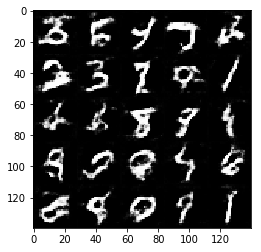

Step 620, Epoch 1/2... Discriminator Loss: 1.8419... Generator Loss: 0.3017
Step 640, Epoch 1/2... Discriminator Loss: 1.5853... Generator Loss: 0.4465
Step 660, Epoch 1/2... Discriminator Loss: 1.5063... Generator Loss: 0.4884
Step 680, Epoch 1/2... Discriminator Loss: 1.7288... Generator Loss: 0.3462
Step 700, Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.7732
Step 720, Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 0.5425
Step 740, Epoch 1/2... Discriminator Loss: 1.5672... Generator Loss: 0.5424
Step 760, Epoch 1/2... Discriminator Loss: 1.5122... Generator Loss: 0.4523
Step 780, Epoch 1/2... Discriminator Loss: 1.2980... Generator Loss: 1.0636
Step 800, Epoch 1/2... Discriminator Loss: 1.5670... Generator Loss: 0.5243


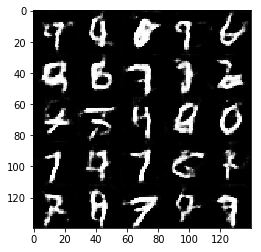

Step 820, Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.6479
Step 840, Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.9492
Step 860, Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 0.8824
Step 880, Epoch 1/2... Discriminator Loss: 1.9204... Generator Loss: 0.2789
Step 900, Epoch 1/2... Discriminator Loss: 1.8088... Generator Loss: 0.3172
Step 920, Epoch 1/2... Discriminator Loss: 1.6572... Generator Loss: 0.4010
Step 940, Epoch 1/2... Discriminator Loss: 1.4219... Generator Loss: 0.5011
Step 960, Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.5347
Step 980, Epoch 1/2... Discriminator Loss: 1.3468... Generator Loss: 0.7334
Step 1000, Epoch 1/2... Discriminator Loss: 1.3358... Generator Loss: 0.6440


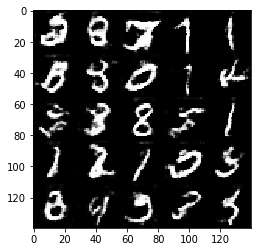

Step 1020, Epoch 1/2... Discriminator Loss: 1.5943... Generator Loss: 0.4352
Step 1040, Epoch 1/2... Discriminator Loss: 1.6350... Generator Loss: 0.3872
Step 1060, Epoch 1/2... Discriminator Loss: 1.7129... Generator Loss: 0.3481
Step 1080, Epoch 1/2... Discriminator Loss: 1.7191... Generator Loss: 0.3264
Step 1100, Epoch 1/2... Discriminator Loss: 1.7215... Generator Loss: 0.3410
Step 1120, Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 1.2407
Step 1140, Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.5567
Step 1160, Epoch 1/2... Discriminator Loss: 1.4224... Generator Loss: 0.5925
Step 1180, Epoch 1/2... Discriminator Loss: 1.8050... Generator Loss: 0.3463
Step 1200, Epoch 1/2... Discriminator Loss: 1.6120... Generator Loss: 0.4018


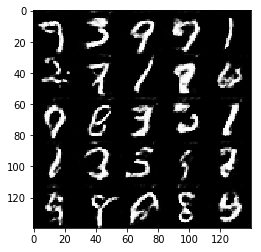

Step 1220, Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 0.7152
Step 1240, Epoch 1/2... Discriminator Loss: 1.6644... Generator Loss: 0.3691
Step 1260, Epoch 1/2... Discriminator Loss: 1.7661... Generator Loss: 0.3469
Step 1280, Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.8372
Step 1300, Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.8230
Step 1320, Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 0.5818
Step 1340, Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 1.6527
Step 1360, Epoch 1/2... Discriminator Loss: 1.6228... Generator Loss: 0.4165
Step 1380, Epoch 1/2... Discriminator Loss: 1.3117... Generator Loss: 0.6318
Step 1400, Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.5995


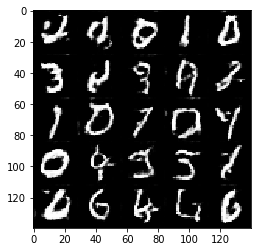

Step 1420, Epoch 1/2... Discriminator Loss: 1.7462... Generator Loss: 0.3333
Step 1440, Epoch 1/2... Discriminator Loss: 1.5313... Generator Loss: 0.4226
Step 1460, Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 1.0147
Step 1480, Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.6373
Step 1500, Epoch 1/2... Discriminator Loss: 1.5613... Generator Loss: 0.4356
Step 1520, Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 1.0276
Step 1540, Epoch 1/2... Discriminator Loss: 1.6836... Generator Loss: 0.3843
Step 1560, Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.9220
Step 1580, Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 0.9272
Step 1600, Epoch 1/2... Discriminator Loss: 1.4816... Generator Loss: 0.4675


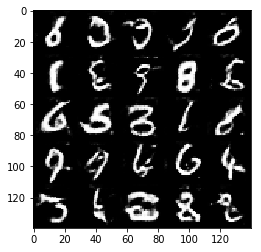

Step 1620, Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.7451
Step 1640, Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 0.5374
Step 1660, Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 0.8764
Step 1680, Epoch 1/2... Discriminator Loss: 1.7895... Generator Loss: 0.3488
Step 1700, Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 1.0125
Step 1720, Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 0.6456
Step 1740, Epoch 1/2... Discriminator Loss: 1.4319... Generator Loss: 1.5077
Step 1760, Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.5969
Step 1780, Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.6181
Step 1800, Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.7712


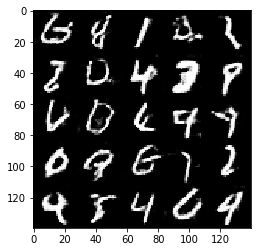

Step 1820, Epoch 1/2... Discriminator Loss: 1.8215... Generator Loss: 0.3121
Step 1840, Epoch 1/2... Discriminator Loss: 1.1158... Generator Loss: 0.8936
Step 1860, Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.9664
Step 1880, Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.4805
Step 1900, Epoch 2/2... Discriminator Loss: 1.7072... Generator Loss: 0.3569
Step 1920, Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 1.2038
Step 1940, Epoch 2/2... Discriminator Loss: 1.7192... Generator Loss: 0.3429
Step 1960, Epoch 2/2... Discriminator Loss: 1.1543... Generator Loss: 1.0804
Step 1980, Epoch 2/2... Discriminator Loss: 1.6777... Generator Loss: 0.3446
Step 2000, Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.5496


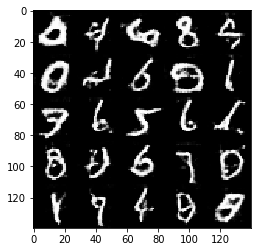

Step 2020, Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.6053
Step 2040, Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.5557
Step 2060, Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 0.6782
Step 2080, Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.5279
Step 2100, Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.6376
Step 2120, Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 0.8006
Step 2140, Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.5786
Step 2160, Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 1.4821
Step 2180, Epoch 2/2... Discriminator Loss: 1.0914... Generator Loss: 1.2593
Step 2200, Epoch 2/2... Discriminator Loss: 1.9074... Generator Loss: 0.2765


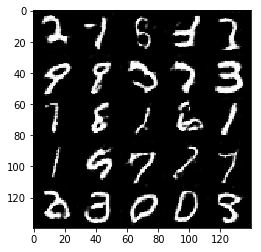

Step 2220, Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 1.1306
Step 2240, Epoch 2/2... Discriminator Loss: 1.7908... Generator Loss: 0.3894
Step 2260, Epoch 2/2... Discriminator Loss: 1.5465... Generator Loss: 0.4518
Step 2280, Epoch 2/2... Discriminator Loss: 1.8440... Generator Loss: 0.3300
Step 2300, Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 0.5948
Step 2320, Epoch 2/2... Discriminator Loss: 1.2866... Generator Loss: 1.1216
Step 2340, Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 1.3437
Step 2360, Epoch 2/2... Discriminator Loss: 1.7829... Generator Loss: 0.3146
Step 2380, Epoch 2/2... Discriminator Loss: 1.5876... Generator Loss: 0.4608
Step 2400, Epoch 2/2... Discriminator Loss: 1.4167... Generator Loss: 0.4938


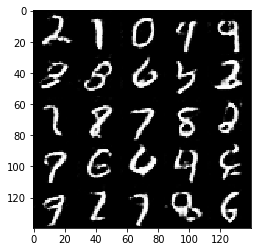

Step 2420, Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.5866
Step 2440, Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.8419
Step 2460, Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 1.1715
Step 2480, Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 1.1500
Step 2500, Epoch 2/2... Discriminator Loss: 1.4687... Generator Loss: 0.4694
Step 2520, Epoch 2/2... Discriminator Loss: 1.1259... Generator Loss: 1.0669
Step 2540, Epoch 2/2... Discriminator Loss: 2.0550... Generator Loss: 0.2480
Step 2560, Epoch 2/2... Discriminator Loss: 1.5224... Generator Loss: 0.5073
Step 2580, Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 1.5640
Step 2600, Epoch 2/2... Discriminator Loss: 1.4293... Generator Loss: 0.5288


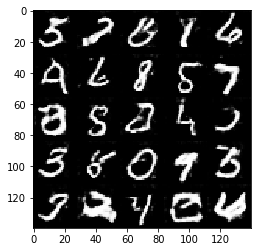

Step 2620, Epoch 2/2... Discriminator Loss: 1.5216... Generator Loss: 0.4721
Step 2640, Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 0.6349
Step 2660, Epoch 2/2... Discriminator Loss: 1.1275... Generator Loss: 1.0721
Step 2680, Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.5434
Step 2700, Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.5245
Step 2720, Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 0.7071
Step 2740, Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 1.7099
Step 2760, Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 0.7944
Step 2780, Epoch 2/2... Discriminator Loss: 1.9108... Generator Loss: 0.2819
Step 2800, Epoch 2/2... Discriminator Loss: 1.2027... Generator Loss: 0.6661


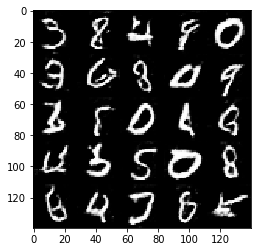

Step 2820, Epoch 2/2... Discriminator Loss: 1.5255... Generator Loss: 0.6893
Step 2840, Epoch 2/2... Discriminator Loss: 2.2149... Generator Loss: 0.1928
Step 2860, Epoch 2/2... Discriminator Loss: 1.7428... Generator Loss: 0.3574
Step 2880, Epoch 2/2... Discriminator Loss: 1.1266... Generator Loss: 0.7417
Step 2900, Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.5705
Step 2920, Epoch 2/2... Discriminator Loss: 0.8702... Generator Loss: 1.8565
Step 2940, Epoch 2/2... Discriminator Loss: 1.6418... Generator Loss: 0.4114
Step 2960, Epoch 2/2... Discriminator Loss: 1.5143... Generator Loss: 0.5047
Step 2980, Epoch 2/2... Discriminator Loss: 1.4270... Generator Loss: 0.5541
Step 3000, Epoch 2/2... Discriminator Loss: 1.6142... Generator Loss: 0.4617


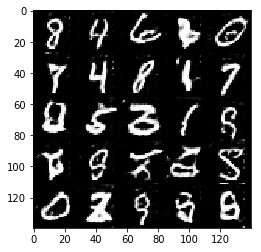

Step 3020, Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 1.0559
Step 3040, Epoch 2/2... Discriminator Loss: 1.3357... Generator Loss: 0.5784
Step 3060, Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.1590
Step 3080, Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 1.0635
Step 3100, Epoch 2/2... Discriminator Loss: 1.9289... Generator Loss: 0.2942
Step 3120, Epoch 2/2... Discriminator Loss: 0.8256... Generator Loss: 1.2076
Step 3140, Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 1.0610
Step 3160, Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.6326
Step 3180, Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 1.5966
Step 3200, Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 0.7238


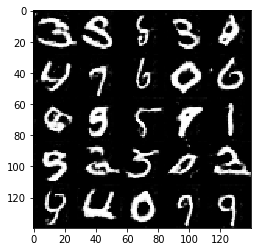

Step 3220, Epoch 2/2... Discriminator Loss: 2.5216... Generator Loss: 0.1813
Step 3240, Epoch 2/2... Discriminator Loss: 1.1781... Generator Loss: 1.7378
Step 3260, Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 0.6344
Step 3280, Epoch 2/2... Discriminator Loss: 1.4535... Generator Loss: 0.4961
Step 3300, Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.6458
Step 3320, Epoch 2/2... Discriminator Loss: 2.2666... Generator Loss: 0.2425
Step 3340, Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 0.8986
Step 3360, Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.6786
Step 3380, Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.5873
Step 3400, Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 0.7015


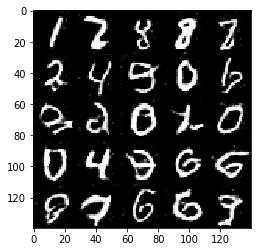

Step 3420, Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.4160
Step 3440, Epoch 2/2... Discriminator Loss: 1.4644... Generator Loss: 0.5124
Step 3460, Epoch 2/2... Discriminator Loss: 1.6387... Generator Loss: 0.3917
Step 3480, Epoch 2/2... Discriminator Loss: 1.5793... Generator Loss: 0.4109
Step 3500, Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 0.8387
Step 3520, Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 0.8249
Step 3540, Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 0.6096
Step 3560, Epoch 2/2... Discriminator Loss: 1.5969... Generator Loss: 0.4333
Step 3580, Epoch 2/2... Discriminator Loss: 2.0518... Generator Loss: 0.2587
Step 3600, Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.5855


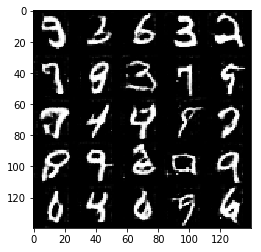

Step 3620, Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.5593
Step 3640, Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.5264
Step 3660, Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.5964
Step 3680, Epoch 2/2... Discriminator Loss: 1.7279... Generator Loss: 0.3903
Step 3700, Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.5275
Step 3720, Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.6352
Step 3740, Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.5452
Final examples


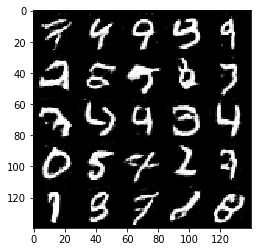

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 40, Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.9387
Step 80, Epoch 1/1... Discriminator Loss: 2.0224... Generator Loss: 0.2686
Step 120, Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.5882
Step 160, Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.4137
Step 200, Epoch 1/1... Discriminator Loss: 1.8605... Generator Loss: 0.3498
Step 240, Epoch 1/1... Discriminator Loss: 1.7863... Generator Loss: 0.4217
Step 280, Epoch 1/1... Discriminator Loss: 1.7746... Generator Loss: 0.4283
Step 320, Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.5655
Step 360, Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.7237
Step 400, Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.5753


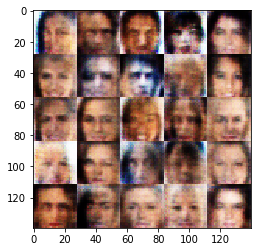

Step 440, Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.5660
Step 480, Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.6213
Step 520, Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7407
Step 560, Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.6370
Step 600, Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7362
Step 640, Epoch 1/1... Discriminator Loss: 1.6219... Generator Loss: 0.5676
Step 680, Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7642
Step 720, Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.7393
Step 760, Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8321
Step 800, Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.7148


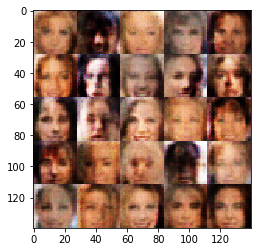

Step 840, Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7414
Step 880, Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.7255
Step 920, Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7513
Step 960, Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7704
Step 1000, Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.7313
Step 1040, Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7141
Step 1080, Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.6551
Step 1120, Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6749
Step 1160, Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.5136
Step 1200, Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.7972


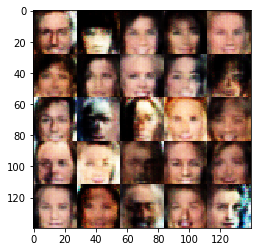

Step 1240, Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.6672
Step 1280, Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.7413
Step 1320, Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.5451
Step 1360, Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6753
Step 1400, Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.5364
Step 1440, Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.5984
Step 1480, Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.5326
Step 1520, Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7908
Step 1560, Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.5384
Step 1600, Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7189


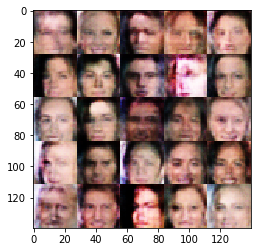

Step 1640, Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6646
Step 1680, Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 0.7333
Step 1720, Epoch 1/1... Discriminator Loss: 1.6773... Generator Loss: 0.5546
Step 1760, Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.5782
Step 1800, Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 0.6336
Step 1840, Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6232
Step 1880, Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.6471
Step 1920, Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7433
Step 1960, Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.6163
Step 2000, Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.6308


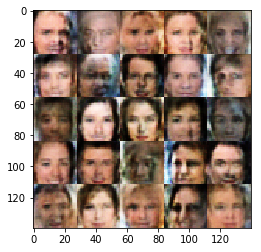

Step 2040, Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.6549
Step 2080, Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7617
Step 2120, Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6044
Step 2160, Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.8152
Step 2200, Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6565
Step 2240, Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6634
Step 2280, Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7395
Step 2320, Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.7184
Step 2360, Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.7258
Step 2400, Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7175


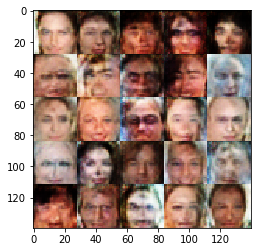

Step 2440, Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.5055
Step 2480, Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6274
Step 2520, Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.6883
Step 2560, Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6234
Step 2600, Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.6334
Step 2640, Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.9846
Step 2680, Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6575
Step 2720, Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.6182
Step 2760, Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.6005
Step 2800, Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.7923


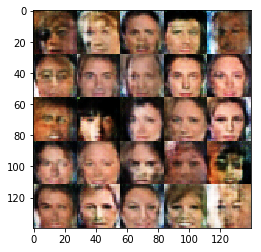

Step 2840, Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.6263
Step 2880, Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6126
Step 2920, Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.5520
Step 2960, Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6260
Step 3000, Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.5874
Step 3040, Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.5037
Step 3080, Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7424
Step 3120, Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.5700
Step 3160, Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6965
Step 3200, Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7653


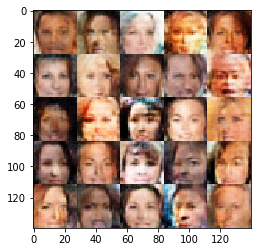

Step 3240, Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.7061
Step 3280, Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7315
Step 3320, Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.5864
Step 3360, Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.6750
Step 3400, Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.5769
Step 3440, Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6551
Step 3480, Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7649
Step 3520, Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7758
Step 3560, Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7538
Step 3600, Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.5882


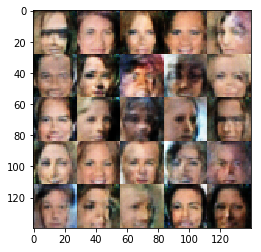

Step 3640, Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7352
Step 3680, Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6685
Step 3720, Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8224
Step 3760, Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.6063
Step 3800, Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.6563
Step 3840, Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.8535
Step 3880, Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8401
Step 3920, Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6674
Step 3960, Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.5668
Step 4000, Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6966


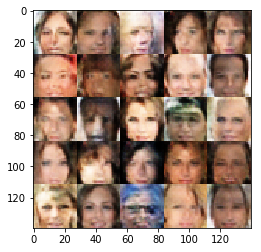

Step 4040, Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.5659
Step 4080, Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7807
Step 4120, Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7012
Step 4160, Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6118
Step 4200, Epoch 1/1... Discriminator Loss: 1.5950... Generator Loss: 0.5877
Step 4240, Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7381
Step 4280, Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7616
Step 4320, Epoch 1/1... Discriminator Loss: 1.5564... Generator Loss: 0.6187
Step 4360, Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7690
Step 4400, Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7062


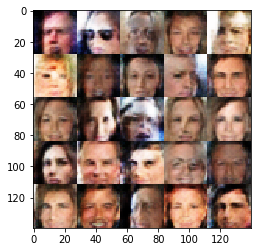

Step 4440, Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6319
Step 4480, Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6830
Step 4520, Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.6116
Step 4560, Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.6714
Step 4600, Epoch 1/1... Discriminator Loss: 1.6103... Generator Loss: 0.5091
Step 4640, Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.6095
Step 4680, Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.8273
Step 4720, Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.6006
Step 4760, Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7301
Step 4800, Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7061


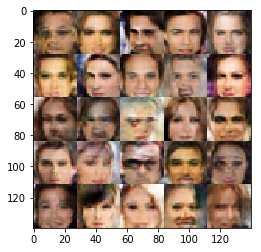

Step 4840, Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.6707
Step 4880, Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7103
Step 4920, Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6095
Step 4960, Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8316
Step 5000, Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7940
Step 5040, Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.8486
Step 5080, Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.6011
Step 5120, Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8667
Step 5160, Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.6474
Step 5200, Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7634


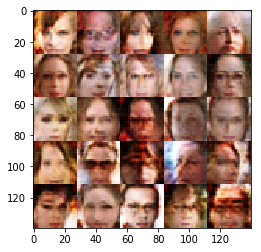

Step 5240, Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.6488
Step 5280, Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6761
Step 5320, Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6541
Step 5360, Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6430
Step 5400, Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.5624
Step 5440, Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.9609
Step 5480, Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6744
Step 5520, Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7661
Step 5560, Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.6075
Step 5600, Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6083


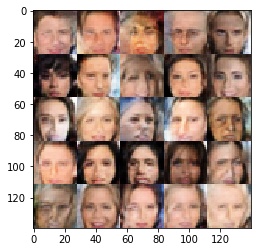

Step 5640, Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7560
Step 5680, Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.6806
Step 5720, Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6849
Step 5760, Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.9773
Step 5800, Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.5562
Step 5840, Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6998
Step 5880, Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6952
Step 5920, Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7592
Step 5960, Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6891
Step 6000, Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.7608


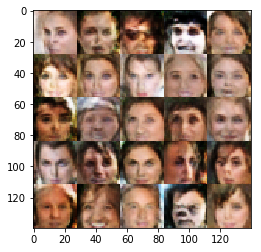

Step 6040, Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7418
Step 6080, Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7588
Step 6120, Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6912
Step 6160, Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7224
Step 6200, Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7006
Step 6240, Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6394
Step 6280, Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.8086
Step 6320, Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6919
Final examples


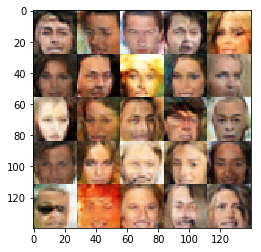

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.